# Application of unsupervised learning

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score


## Spotify Tracks Dataset

The dataset contains audio feature data from Spotify for a large number of tracks across 125 different musical genres. Each entry includes various characteristics of a song — such as its tempo, danceability, energy, and more — along with metadata like the artist, album, track name, and genre.

These features are automatically generated by Spotify's internal audio analysis tools, providing a detailed, quantitative description of each track’s musical attributes. This dataset allows for a data-driven exploration of music, moving beyond user-generated tags or opinions.

**Source:**  
[Spotify Tracks Dataset on HuggingFace](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset)


## Problem Statement

In this project, we aim to explore whether it is possible to uncover meaningful groupings of songs based solely on their audio characteristics, without using any genre labels during training. Particularly, the goal is to see if we can find genres in the clusters generated through unsupervised learning

Such an approach can have several useful applications:
- Music recommendation systems
- Automatic playlist generation
- Discovering new or emerging genres
- Organizing massive music libraries


## Selected Features

To focus purely on the musical content of each track, we will drop metadata such as artist name or album and retain only the **numeric audio features**. These features describe the composition and acoustic properties of a track.

Here are the selected features and their meanings:

- **danceability**: Float [0.0–1.0]  
  Indicates how suitable a track is for dancing, based on tempo, rhythm stability, beat strength, etc.

- **energy**: Float [0.0–1.0]  
  Represents the intensity and activity level of the track.

- **key**: Integer [0–11]  
  The estimated musical key.

- **loudness**: Float (in dB)  
  The overall loudness of the track.

- **mode**: Binary (0 = minor, 1 = major)  
  Indicates whether the track is in a major or minor scale.

- **speechiness**: Float [0.0–1.0]  
  Detects the presence of spoken words in the track.

- **acousticness**: Float [0.0–1.0]  
  Measures confidence that the track is acoustic.

- **instrumentalness**: Float [0.0–1.0]  
  Predicts the likelihood that a track contains no vocals.

- **liveness**: Float [0.0–1.0]  
  Estimates whether the track was recorded in front of an audience.

- **valence**: Float [0.0–1.0]  
  Describes the musical "positiveness" conveyed by the track.

- **tempo**: Float (BPM)  
  The speed of the track in beats per minute.

- **duration_ms**: Integer (milliseconds)  
  The duration of the track.

- **time_signature**: Integer [3–7]  
  Estimated number of beats per measure.

  - **explicit**: Bool  
  Wether or not a song contains curse words.



# Data Preprocessing

Before applying any unsupervised learning techniques, we need to prepare and clean the data:


In [138]:
ds = load_dataset("maharshipandya/spotify-tracks-dataset")["train"]

df = pd.DataFrame(ds)

print("initial shape:", df.shape)
df.head(1)

initial shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,acoustic


###  Drop Unnecessary Columns + Keep Relevant Features

In [139]:
df = df.drop(columns=['Unnamed: 0'])
le2 = LabelEncoder()
le = LabelEncoder()
numeric_df = df.select_dtypes(include=['number'])

numeric_df = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'popularity'])
numeric_df['explicit'] = le2.fit_transform(df['explicit'])
numeric_df['track_genre'] = le.fit_transform(df['track_genre'])

numeric_df.head(1)

numeric_df_without_genre = numeric_df.drop(columns=['track_genre'])


# Exploratory Data Analysis and Structure of the data

### Distribution of features

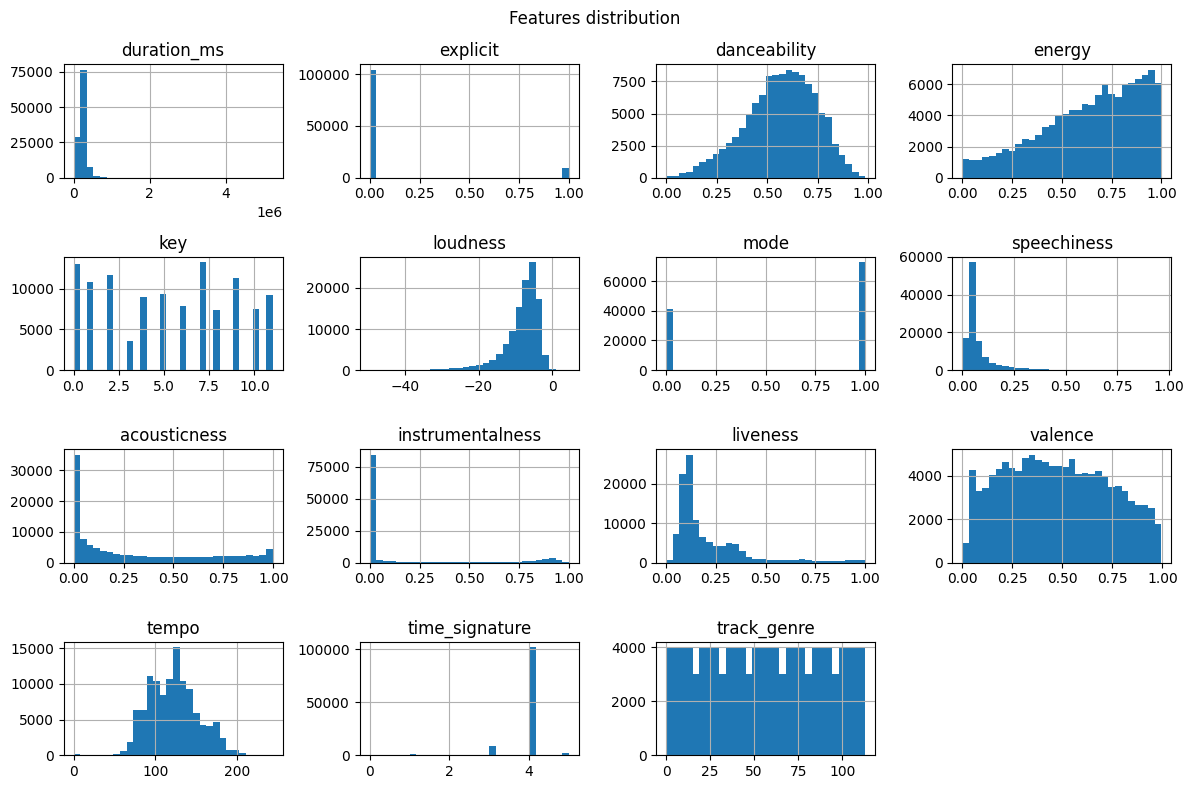

In [140]:
cols =  numeric_df.columns
numeric_df[cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Features distribution")
plt.tight_layout()
plt.show()

### Analysis of the correlation matrix 
Here, the objective is to see whether of not some caracterstics align on the same musical dimension

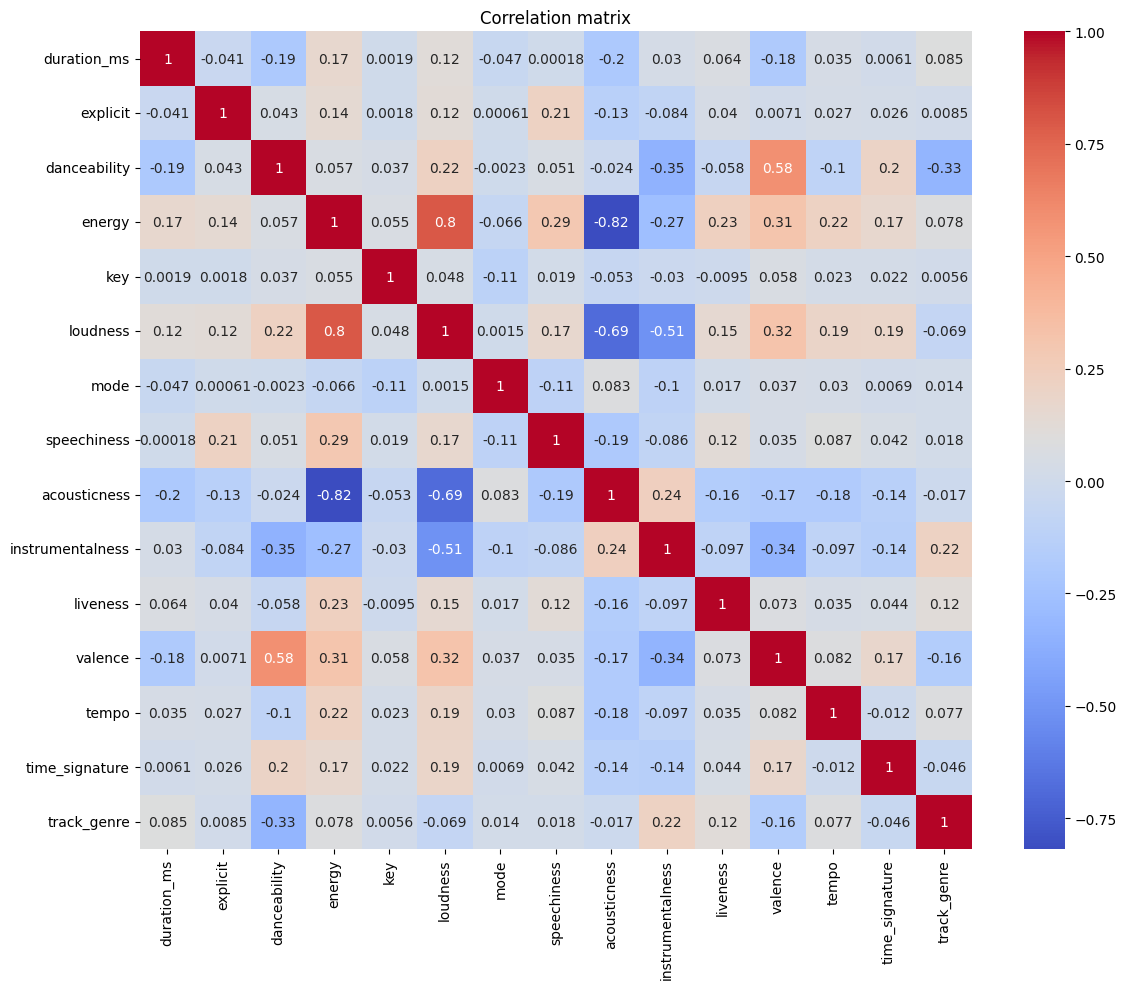

In [169]:
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

**Popularity**

The distribution is biased toward lower values, suggesting that the dataset contains many less known or rarely played tracks.
There is no strong correlation between popularity and any other variable. This suggests that popularity is largely independent of audio features.

**Loudness, Energy, Acousticness, and Instrumentalness**

Loudness is strongly correlated with:

- Energy (0.76): energetic tracks tend to be louder.

- Acousticness (-0.59) and Instrumentalness (-0.43): those tracks are typically softer.

Loud tracks are generally energetic, not acoustic, and rarely instrumental. The later is interesting since there is a lot of eletronic songs, this is a dataset bias that we explain later.

**Danceability**

Danceability is positively correlated with:

- Valence (0.48): happy songs tend to be more danceable.

- Loudness (0.26) and Energy (0.26): danceable music is usually louder and more energetic.

Danceable songs tend to be happy, energetic, and loud.

**Speechiness**

Speechiness is correlated with:

- Explicit (0.31): tracks with more spoken content are more likely to contain explicit lyrics.

- Liveness (0.21): live recordings may include spoken segments or interactions with the audience.

Speechy tracks are more likely to be explicit and performed live.


**Mode and Key**

Both show very low or no correlation with other features.

Mode is weakly correlated with Acousticness (0.10), this might be caused by minor keys. It is interesting that there is no correlation with the Valence.
Key appears to have no meaningful relationship with other features and could be discarded.

These features might be useless.

**Tempo**

Tempo correlates with Energy (0.25) and Valence (0.13)

Faster tracks tend to be more energetic and a bit positive.

Also, Tempo values equal to zero likely represent invalid or missing data and should be removed.

**Time Signature**

This feature shows very low variance, with a strong dominance of 4/4 time and very few instances of 3/4.

All values are in x/4 format meaning there is no representation of compound meters such as 6/8 or 9/8.

Time signature does not capture complex rythme (ternary,...) and provides no discriminative power. We could remove it.

**Track Genre**

The genre distribution appears relatively balanced across classes.
There are no strong correlations between genre and other features, which is expected for a well balanced classification task.
It suggests that genres in the dataset are not trivially predictable and reflects realistic musical complexity.

# Contraints imposed by the problem

When doing this execice we realised that in order to be able to read the graphs we wanted to plot we could not keep all genres. Instead of merging different genres into one and therefore adding personal bias into the problem we decided to select *n* random genres to answer the problem (we take the first *n* so that results dont differ when you run the code multiple times). 

In [170]:
all_genres = numeric_df['track_genre'].unique()
print(f"Total genres: {len(all_genres)}")

all_genres_sorted = sorted(all_genres) 
n_genres_to_keep = 8
selected_genres = all_genres_sorted[:n_genres_to_keep]

print(f"Genres afer selection ({len(selected_genres)}):")
for i, genre in enumerate(selected_genres, 1):
    print(f"{i:2d}. {genre}")

lenOld = len(numeric_df)
numeric_df = numeric_df[numeric_df['track_genre'].isin(selected_genres)]
print(f"\n {len(numeric_df)} point (on {lenOld} initial)")


numeric_df_without_genre = numeric_df.drop(columns=['track_genre'])

Total genres: 8
Genres afer selection (8):
 1. 0
 2. 1
 3. 2
 4. 3
 5. 4
 6. 5
 7. 6
 8. 7

 8000 point (on 8000 initial)


### Dimensional reduction with PCA and visualisation
We now reduce the data’s dimensionality—not for clustering directly, but to visualize and understand its structure.
The goal is to see whether the data naturally forms groups, and whether those groups align with the genres of the songs.

To evaluate how well the songs separate into meaningful groups, we use the Silhouette Score.

- The Silhouette Score measures how similar each point is to its own cluster compared to other clusters.

- It ranges from -1 (bad clustering) to 1 (well-separated clusters).

- A value close to 0 indicates overlapping or ambiguous clusters.

We are coloring points by their true genre labels to visualize the PCA. But PCA itself is unsupervised — it doesn't use the genre labels to create the axes.

Later, when we apply unsupervised clustering algorithms, we will also compute silhouette scores on the predicted clusters to compare their quality and relevance.

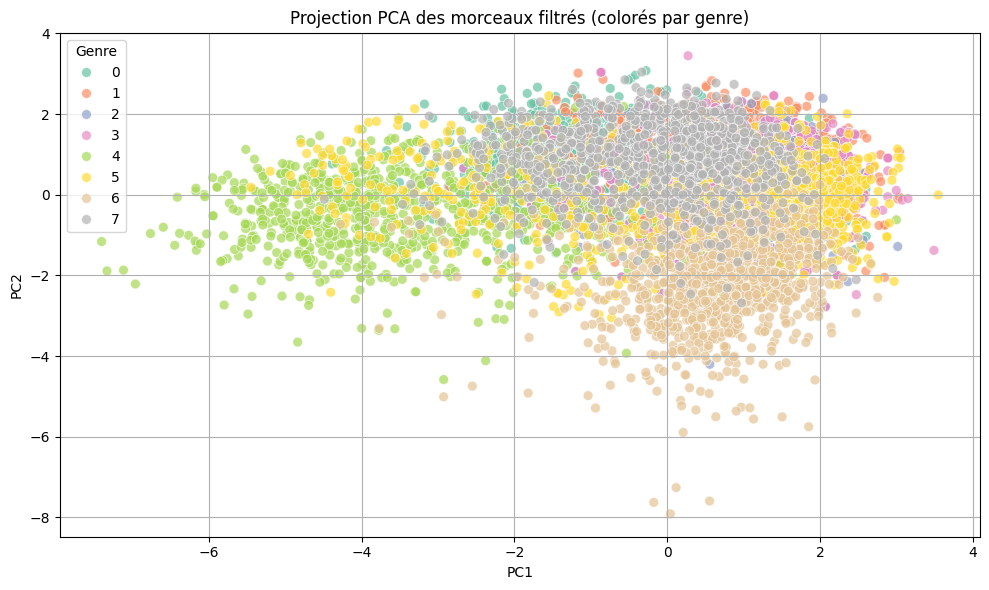

Silhouette Score (with genres as labels) : -0.0411


In [171]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df_without_genre)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

df_pca['Genre'] = numeric_df['track_genre'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Genre', palette='Set2', s=50, alpha=0.7)
plt.title("Projection PCA des morceaux filtrés (colorés par genre)")
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df_pca['Genre'])

score = silhouette_score(X_pca, labels)
print(f"Silhouette Score (with genres as labels) : {score:.4f}")


### Analysis 



- **Silhouette Score**: `-0.0411`.A negative Silhouette Score indicates that, on average, **songs are closer to samples from other genres than to their own**. This suggests that the genres **do not form clearly separated clusters** in the PCA 2D space.

- **Visuals**: It might be surprising that the Silhouette Score is low even though the PCA plot looks like it's forming some unprecise color clusters (with a lot of overlapping). PCA only shows 2 dimensions, but our data lives in a higher-dimensional space. So, even if two poitns might seem close in 2D, it doesn’t reflect their real distance in the original space 
The **Silhouette Score** is a metric that evaluates how well each data point fits into its assigned cluster, compared to other clusters. It is defined using two quantities:

- **a(i)**: the average distance between a point *i* and all other points in the **same** cluster.
- **b(i)**: the average distance between point *i* and all points in the **nearest** different cluster.

Then the **silhouette score** for a point *i* is calculated as: $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$
When projected into 2D, many distances flatten or overlap, causing small differences between *a(i)* and *b(i)* or even worse clustering than expected → negative scores


- PCA is a **linear** dimensionality reduction method and is designed to capture variance, not necessarily cluster separability so it is not suprising that the results are not great. We can also note that genres in music often **overlap in acoustic features** , which may explain the poor separation.

This score will be a **baseline** for comparison with unsupervised clustering results later on.


### Clustering

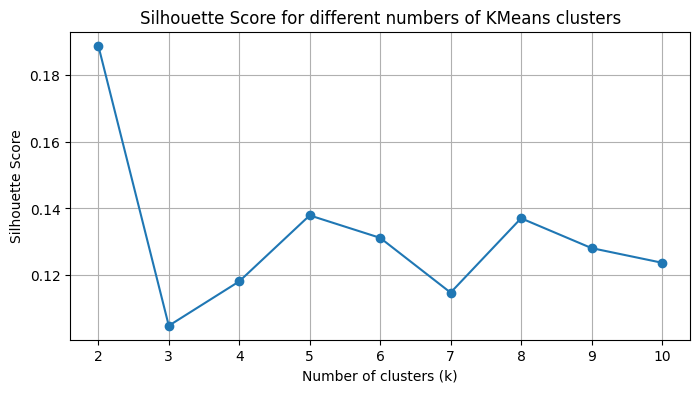

In [159]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df_without_genre)

sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(k_values, sil_scores, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for different numbers of KMeans clusters")
plt.grid(True)
plt.show()

### Analysis

We could have expected the best silhouette score to be at k = 8 (because track_genre has 8 genres), but the best score was at k = 2.

k = 2 often gets the highest score because it's easy to split data into two broad and well-separated clusters. As we increase k, clusters get smaller and closer together, which lowers the silhouette score, especially if the data doesn’t naturally fall into that many distinct blobs. We can note that apart from k=2 the two other highest silhouette scores fall at k=5 and k=8 (which was the expected value if our data clustered right into the genres). k=5 having a high silhouette score could be explained by some of our genre having features that fall close together. 

Overall, we can't conclude from this clustering that unsupervised clustering falls into genres even if it leaves clues of it.


#  Gaussian Mixture Model (GMM)

KMeans assumes hard boundaries and equal-sized, spherical clusters. GMM allows soft clustering (probabilistic membership) and elliptical cluster shapes, which can better model real-world data like music features, where boundaries between genres are fuzzy.

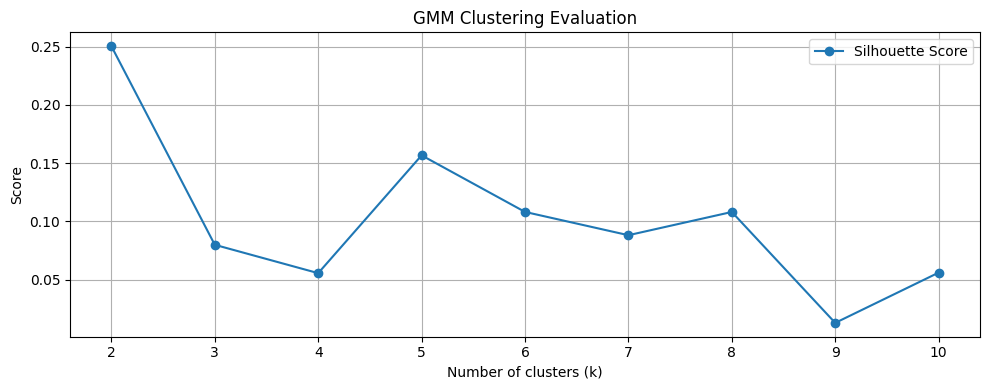

In [167]:
sil_scores = []
k_values = range(2, 11)

le = LabelEncoder()
true_labels = le.fit_transform(numeric_df['track_genre'])

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    cluster_labels = gmm.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, cluster_labels)
    
    sil_scores.append(sil)
    ari_scores.append(ari)

plt.figure(figsize=(10, 4))
plt.plot(k_values, sil_scores, marker='o', label='Silhouette Score')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.title("GMM Clustering Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Analysis

The plot of Silhouette score for GMM ressembles the one for Kmeans only with slighly better values and a bigger gap between k=5 and k=8. Notably with a 0.25 for k=2. 

Why is k = 2 often the best once again?
When the structure of the data is not clearly separable into many compact clusters, both KMeans and GMM tend to find a broad high-level separation — for example, splitting tracks into “energetic” vs. “calm,” or “acoustic” vs. “electronic” and easily split the datapoints into 2 clusters. A silhouette score rewards cohesion and separation, which is easiest to achieve with just 2 well-separated groups, even if those don’t align with meaningful genres.

What about k = 5 and k = 8?
The fact that k = 5 and k = 8 also show relatively high scores suggests that some substructure related to genre might exist, but the genres are not cleanly separated. It’s possible that some genres are sonically close (e.g., hip hop vs. trap), and GMM sometimes merges or splits them based on subtle feature differences.
